**Manchas de petróleo (2019) - IBAMA**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

url = "http://www.ibama.gov.br/phocadownload/emergenciasambientais/2019/manchasdeoleo/2019-12-02_LOCALIDADES_AFETADAS.xlsx"
df = pd.read_excel(
    url,
    parse_dates=["Data_Avist", "Data_Revis"],
)

# Calculando o tempo de permanência da mancha em cada localidade
df["dias"] = (df["Data_Revis"] - df["Data_Avist"]).dt.days

# tratando as colunas de tempo
df['Data_Avist'] = df['Data_Avist'].dt.strftime('%Y-%m-%d').str.replace('NaT', 'na')
df["Data_Revis"] = df["Data_Revis"].dt.strftime("%Y-%m-%d").str.replace("NaT", "na")
df["dias"] = df["dias"].astype('Int64').astype(str).str.replace("nan", "na")

df.dropna(inplace=True)

In [ ]:
# um pouco de limpeza de dados (data cleaning)

# removendo linhas onde o status == nao observado
filtr = (df['Status'] == df['Status'].unique()[2])

df = df[~filtr].copy()

# removendo registros onde o dias == 0
filtr = (df['dias'] == 0)
df = df[~filtr].copy()

df.head()

In [ ]:
# Estado mais afetado
df.groupby('sigla_uf').count()['estado'].plot(kind='barh')

In [ ]:
# Município mais afetado
df.groupby('municipio').count()\
        .sort_values(by='Data_Revis', 
                     ascending=False)\
        .head(10)

In [ ]:
# primeiros e ultimos afetados
df[df['Data_Avist'] == df.min()['Data_Avist']].head(5)

# df[df['Data_Revis'] == df.max()['Data_Revis']].head(5)

In [ ]:
# afetados por mais tempo
df.groupby(by='localidade').sum().sort_values('dias', ascending=False).head(5)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# funcao: será utilizada no date_parser
def dateparse(x):
    return pd.datetime.strptime(x, '%Y %m %d %H %M')

# podemos usar funções lambda
# dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')

df = pd.read_csv('../dados/pnboia_vitoria.csv',
                 parse_dates={'datetime': ['Year', 'Month', 'Day', 'Hour', 'Minute']},
                 date_parser=dateparse,
                 decimal=',',
                 )

# agora podemos converter nossa coluna datetime em index
df.set_index('datetime', inplace=True)

# replace numeros invalidos
df = df.replace(-9999.0, np.nan)

from windrose import WindroseAxes
import matplotlib.cm as cm

ws = df['Wspd']
wd = df['Wdir']

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

/home/danilo/miniconda3/envs/doc_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


# Aula 6 - Mapas

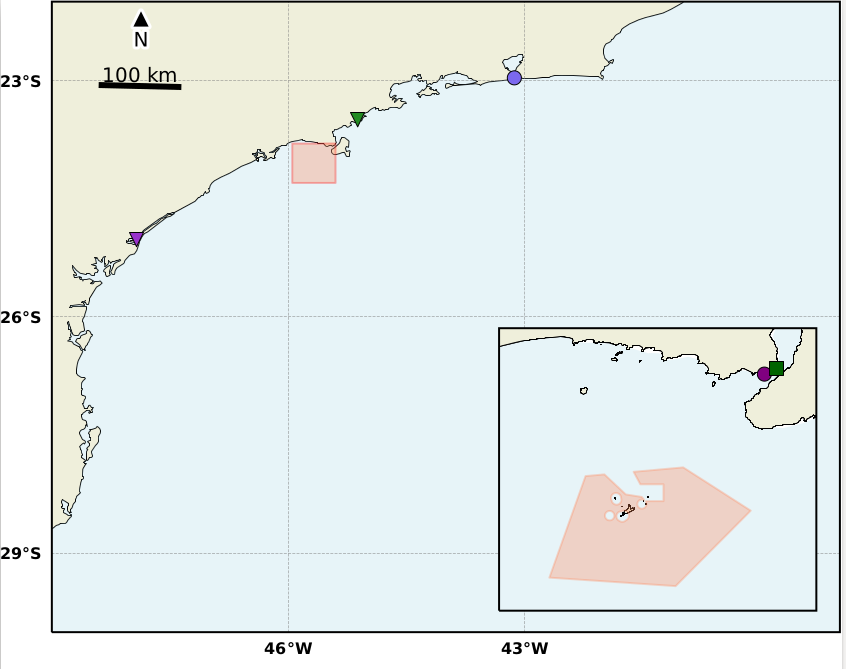

**materiais de apoio**

- Documentação cartopy:
- NaturalEarth: conjunto de informações geográficas de acesso público [[link]](https://www.naturalearthdata.com/downloads/) ou [[link]](https://github.com/nilodna/natural-earth-vector/tree/master/packages/Natural_Earth_quick_start)
- OpenStreetMap: iniciativa colaborativa para acesso livre à informações geográficas [[link]](https://download.geofabrik.de/south-america/brazil.html)
- 

### O que é cartopy?

É um pacote feito especificamente para processar dados geoespaciais no python. Utiliza como background pacotes como PROJ4, NumPy e Shapely, além do Matplotlib para criação dos mapas.

No geral, produz mapas com qualidade de publicação, tendo sido utilizado inclusive por jornalistas em jornais de alto impacto, como New York Times. 

Como tudo no python, com o cartopy você tem total controle sobre os elementos cartográficos, podendo editá-los de forma fácil, porém nem sempre intuitiva.

Hoje, iremos reproduzir o mapa apresentado acima, apresentando os principais métodos disponíveis no cartopy, além de algumas projeções.

**Criando geofiguras (GeoAxes)**

Quando tratamos de visualizações geoespaciais com o cartopy, precisamos criar um ```GeoAxes```, integrando matplotlib e cartopy e selecionando a projeção cartográfica que iremos utilizar na visualização.

Existem duas alternativas para se fazer isso, cada qual com suas aplicações. 

1. Criando figura e eixo geográfico separadamente:

```python
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.PlateCarree())
```

2. Criando tudo junto:

```python
fig,ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
```

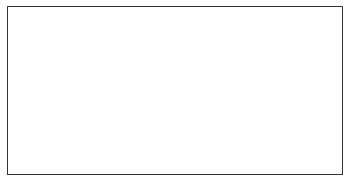

In [4]:
import matplotlib.pyplot as plt
# padrão de importação: crs é o core do pacote
import cartopy.crs as ccrs

%matplotlib inline

# modo 1:
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.PlateCarree())

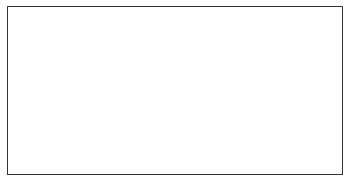

In [5]:
fig,ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

Nos exemplos acima, apenas uma tela em branco é criada, pois ainda não inserimos nenhuma informação em nosso mapa. 

**Principais métodos disponíveis**

Quando falamos em mapas, o primeiro elemento cartográfico que queremos inserir é a linha de costa. Além de outras informações, rios, países, lagos, ilhas. Além disso, devemos realizar ajustes importantes, como inserir os meridianos e paralelos, escala horizontal, etc.

Para inserir todas estas informações, utilizamos uma série de métodos disponíveis no pacote. Iremos ver brevemente alguns destes métodos agora, porém de fato iremos explorar estas possibilidades mais a frente.

- **ax.coastlines():** inserir linha de costa
- **ax.set_global():** ajusta limites geográficos para o globo
- **ax.set_extent():** ajusta os limites geográficos para uma região
- **ax.stock_img():** adiciona uma imagem padrão ao mapa
- **ax.imshow():** adiciona imagem personalizada ao mapa
- **ax.add_geometries():** adiciona geometrias do shapely (pacote de leitura de shapefiles)
- **ax.gridlines():** adiciona linhas de grade associadas às coordenadas

In [14]:
# apenas pq podemos, vamos criar uma função para retornar um mapa

def create_map(projection):
    fig,ax = plt.subplots(subplot_kw={'projection': projection})
    
    return fig,ax

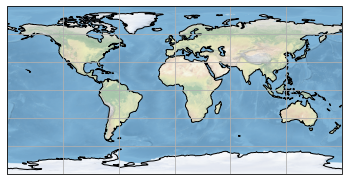

In [17]:
proj = ccrs.PlateCarree()

fig,ax = create_map(proj)

# adicionando linha de costa
ax.coastlines()

# adicionando gridline
ax.gridlines()

# adicionando imagem padrão
ax.stock_img()

Com algumas poucas linhas já temos uma imagem bem legal do globo. Porém, podemos ir além e melhorar ainda mais essa figura, inserindo outros elementos cartográficos.

Antes disso, vamos falar um pouco sobre projeções.

### Projeção de mapas: problemas

Inevitalmente, ao projetarmos uma esfera em uma superfície 2D, iremos obter distorções. Isso porquê a superfície de uma esfera é topologicamente diferente da superfície 2D e, quando fazemos a projeção, precisamos cortar alguns trechos da esfera.

![image.png](https://raw.githubusercontent.com/SciTools/cartopy-tutorial/master/static/orange_peel.jpg)

Mais informações sobre as distorções geradas pelas projeções de esferas em planos, leia esta discussão sobre qual projeção escolher para cada caso: [[link]](https://github.com/SciTools/cartopy-tutorial/blob/master/tutorial/projections_crs_and_terms.ipynb)

Iremos listar algumas projeções disponíveis no cartopy, porém consulte este [[link]](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html) para obter uma lista completa.

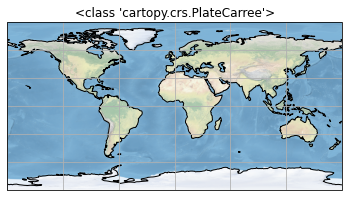

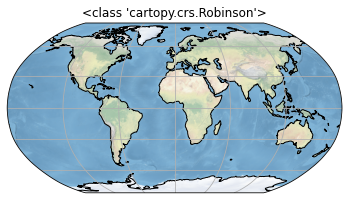

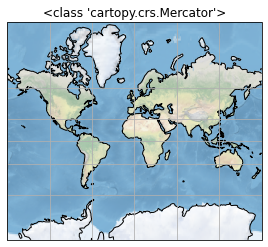

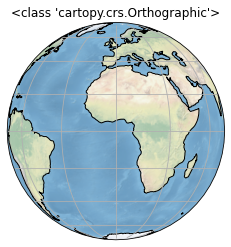

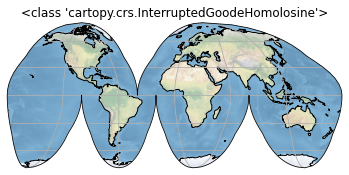

In [20]:
projecoes = [ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Mercator(),
               ccrs.Orthographic(),
               ccrs.InterruptedGoodeHomolosine()
            ]

for proj in projecoes:
    fig,ax = create_map(proj)
    ax.coastlines()
    ax.stock_img()
    ax.gridlines()
    ax.set_title(f'{type(proj)}')

## Criando um mapa regional

Sabemos o básico de cartopy e podemos agora começar a criar um mapa, por exemplo, de uma área de estudo.

Usarei como exemplo o mapa apresentado no início. Trata-se de um mapa da Plataforma Continental Sudeste (PCSE), com a Unidade de Conservação do Arquipélado de Alcatrazes focalizada. Além disso, alguns pontos de observações foram inseridos, indicando a localização de estações meteorológicas e fundeios.


In [23]:
# importando diversos pacotes novos
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
# pacotes relacionados às funcionalidades do cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom

**primeiros passos**

O primeiro passo para elaborarmos um mapa regional é selecionar a projeção que iremos utilizar, baseado no tipo de informação que queremos visualizar e também a região que queremos ilustrar.

No nosso caso, iremos utilizar a projeção mais utilizada e que já vimos há pouco (```ccrs.PlateCarree()``` ). Depois, temos que estabelecer os limites geográficos. E, para isso, precisamos conhecer duas coordenadas específicas:

- latitude e longitude do canto inferior esquerdo
- latitude e longitude do canto superior direito

A partir disto, podemos usar o método ```.set_extent()``` para criar estes limites.

In [105]:
# projecao
proj = ccrs.PlateCarree()

# posicao do canto inferior esquerdo
lower_lon = -50
lower_lat = -30

# posicao do canto superior direito
upper_lon = -41
upper_lat = -22

Por padrão, o método ```.coastlines()``` utiliza um conjunto de linha de costa disponibilizado publicamente pelo [Natural Earth](https://www.naturalearthdata.com/). Este conjunto possui três tripos de escalas:

- 1cm:10m (padrão utilizado pelo método)
- 1cm:50m
- 1cm:110m

Como não há necessidade de se fazer download do banco de dados, pois isto é feito automaticamente pelo cartopy, a primeira vez que você rodar o código para gerar a figura, pode demorar um bocado (processo de download). No entanto, o arquivo baixado é salvo temporariamente em seu computador e, portanto, os próximos mapas feito serão feitos mais rapidamente. Quando o terminal do python for encerrado, o arquivo é removido.

Além disso, outros conjuntos estão disponíveis, como recifes de coral, fronteiras entre países, etc. Vale a pena dar uma conferida.

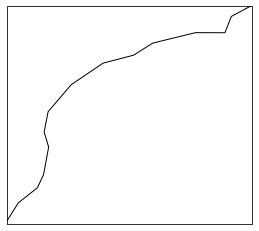

In [106]:
# montando uma lista para facilitar enviar para o GeoAxes
# os limites geográficos. 
extent = [lower_lon, upper_lon, lower_lat, upper_lat]

# criando mapa com a função 
fig,ax = create_map(ccrs.PlateCarree())

# alterando para os limites criados acima
ax.set_extent(extent)

# inserindo linha de costa com resolução 
# de 1:110, teste com 10m e 50m
ax.coastlines('110m')

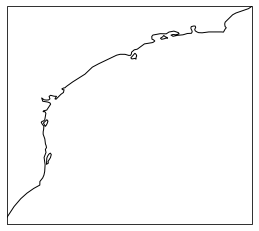

In [107]:
extent = [lower_lon, upper_lon, lower_lat, upper_lat]

fig,ax = create_map(ccrs.PlateCarree())
ax.set_extent(extent)
ax.coastlines('50m')

Ainda, temos a possibilidade de importar do conjunto NaturalEarth outras informações, utilizando o subpacote ```cartopy.feature```. 

Vejamos o exemplo para inserir o continente com a mesma resolução que a linha de costa que queremos trabalhar e também cores ao oceano:

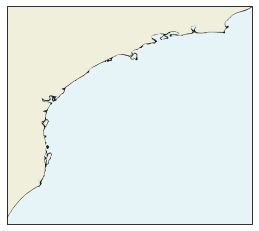

In [108]:
import cartopy.feature as cfeature

fig,ax = create_map(ccrs.PlateCarree())
ax.set_extent(extent)
ax.coastlines('10m')

coastline_10m = cfeature.NaturalEarthFeature(
    category='physical',name='coastline',scale='10m',
    facecolor=cfeature.COLORS['land'])

bathy_0m      = cfeature.NaturalEarthFeature(
    category='physical',name='bathymetry_L_0',scale='10m')

# inserting information over the map
ax.add_feature(coastline_10m, 
               edgecolor='black',
               linewidth=.05)
ax.add_feature(bathy_0m,
               facecolor='lightblue',
               alpha=.3)

Para facilitar os próximos passos, vamos inserir todo o bloco de códigos acima em uma função, chamada ```make_map()```:

In [136]:
def make_map(fig=None, ax=None, extent=[-50,-41,-30,-22], projection=ccrs.PlateCarree()):
    """ 
    documente-a como exercício para entender a 
    ação de cada linha
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    coastline_10m = cfeature.NaturalEarthFeature(
        category='physical',name='coastline',scale='10m',
        facecolor=cfeature.COLORS['land'])

    bathy_0m      = cfeature.NaturalEarthFeature(
        category='physical',name='bathymetry_L_0',scale='10m')

    # inserting information over the map
    ax.add_feature(coastline_10m, 
                   edgecolor='black',
                   linewidth=.1)
    ax.add_feature(bathy_0m,
                   facecolor='lightblue',
                   alpha=.3)
    
    return ax

Para finalizar os elementos básicos do nosso mapa, precisamos inserir as informações de latitude e longitude para indicar a região que estamos apresentando.

Fazemos iso com o método ```.gridlines()``` já visto, mas iremos além, para configurar mais detalhamente nossos meridianos e paralelos.

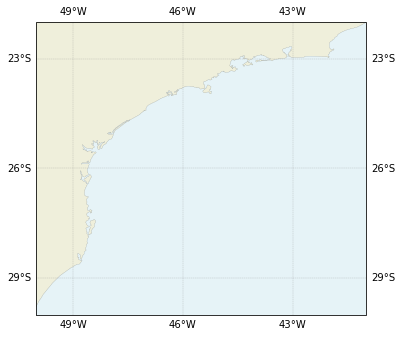

In [138]:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())

# criando as gridlines utilizando os limites geográficos como 
# referência (xlocs e ylocs)
# Ainda, definimos a grossura, cor e transparência das linhas, de 
# modo a não prejudicarem a visualização da informação mais 
# importante do mapa.
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.4, color='gray', 
                  alpha=0.5, linestyle='--', 
                  xlocs=np.linspace(extent[0], extent[1], 5),
                  ylocs=np.linspace(extent[3], extent[2], 5))

Notem que, por padrão, os rótulos aparecem ao redor do nosso mapa. Podemos omitir, por exemplo, os rótulos superiores e à direita.

Ainda, para tornar ainda melhor a nossa visualização, podemos configurar estes rótulos com cor, tamanho, fonte, estilo, etc.

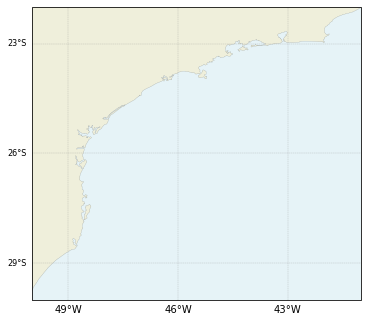

In [139]:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())

# criando as gridlines utilizando os limites geográficos como 
# referência (xlocs e ylocs)
# Ainda, definimos a grossura, cor e transparência das linhas, de 
# modo a não prejudicarem a visualização da informação mais 
# importante do mapa.
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.4, color='gray', 
                  alpha=0.5, linestyle='--', 
                  xlocs=np.linspace(extent[0], extent[1], 5),
                  ylocs=np.linspace(extent[3], extent[2], 5))

gl.top_labels = False
gl.right_labels = False

# dicionario com configurações dos rótulos
dict_style_labels = {
    'color': 'black',
    'fontsize': 8
}

gl.ylabel_style = dict_style_labels

Para facilitar ainda mais, vamos inserir essas configurações de meridianos e paralelos em um outra função. Assim conseguiremos reproduzir nosso mapa básico com poucas linhas e não precisaremos nos repetir mais (lembrem-se: DRY: _don't repeat yourself_).

In [94]:
def configuring_map(ax, extent):
    # criando as gridlines utilizando os limites geográficos como 
    # referência (xlocs e ylocs)
    # Ainda, definimos a grossura, cor e transparência das linhas, de 
    # modo a não prejudicarem a visualização da informação mais 
    # importante do mapa.
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.4, color='gray', 
                      alpha=0.5, linestyle='--', 
                      xlocs=np.linspace(extent[0], extent[1], 5),
                      ylocs=np.linspace(extent[3], extent[2], 5))

    gl.top_labels = False
    gl.right_labels = False

    # dicionario com configurações dos rótulos
    dict_style_labels = {
        'color': 'black',
        'fontsize': 8
    }

    gl.ylabel_style = dict_style_labels

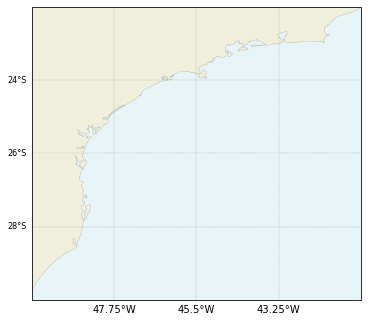

In [140]:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent)

Agora temos duas funções que nos ajudarão a reproduzir a base do nosso mapa. Criando os principais elementos cartográficos, de forma fácil e, percebam, podemos reproduzir para qualquer região do globo usando essas duas funções.

Portanto, vocês podem começar a pensar a criar uma rotina python com as suas funções, para que as usem frequentemente.

![image.png](../figures/247.gif)

**Unidade de Conservação**

Começaremos criando os limites geográficos para o nosso mini mapa, que será responsável por ilustrar com maiores detalhes a região da Unidade de Conservação que queremos exibir.

Além disso, iremos utilizar o subpacote ```shapely.geometry``` (que nomearemos como ```sgeom```) para inserir um polígono delimitando, no mapa, a região que corresponde ao minimapa.

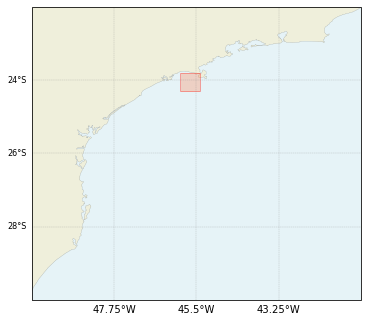

In [141]:
import shapely.geometry as sgeom

# coordenadas geográficas do limite do minimapa
lower_lat = -24.3
lower_lon = -45.949
upper_lat = -23.8
upper_lon = -45.4

extent_UC = [lower_lon, upper_lon, lower_lat, upper_lat]

# usando um método novo do matplotlib, criamos um polígono
extent_box = sgeom.box(extent_UC[0], extent_UC[2], 
                       extent_UC[1], extent_UC[3])

# testando o código:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent)
ax.add_geometries([extent_box], ccrs.PlateCarree(), 
                  facecolor='coral', # cor do polígono
                  edgecolor='red',   # cor das arestas
                  alpha=.3)          # transparência

O próximo passo é inserir, de fato, o minimapa com a região destacada. Para isso, utilizaremos uma técnica do matplotlib para criar novos ```axis``` em uma figura, mas estabelecendo com precisão o local que ele será criado (```rect```).

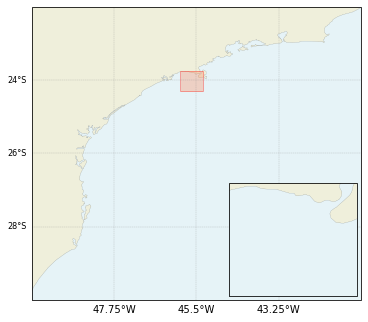

In [144]:
import shapely.geometry as sgeom

# coordenadas geográficas do limite do minimapa
lower_lat = -24.3
lower_lon = -45.949
upper_lat = -23.74
upper_lon = -45.32

extent_UC = [lower_lon, upper_lon, lower_lat, upper_lat]

# usando um método novo do matplotlib, criamos um polígono
extent_box = sgeom.box(extent_UC[0], extent_UC[2], 
                       extent_UC[1], extent_UC[3])

# criando a base do mapa:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent)

# adicionando polígono no mapa
ax.add_geometries([extent_box], ccrs.PlateCarree(), 
                  facecolor='coral', # cor do polígono
                  edgecolor='red',   # cor das arestas
                  alpha=.3)          # transparência

# setting axes position and size
left,bottom   = 0.465, 0.25
width, height  = 0.55, 0.20
rect = [left,bottom,width,height]

# creating axes 2 for minimap
ax2 = plt.axes(rect, projection=ccrs.PlateCarree())
ax2 = make_map(fig=fig, ax=ax2, extent=extent_UC)

Notem que na figura acima, o minimapa contempla parte de Ilha Bela, um trecho de São Sebastião, mas não aparece o Arquipélago de Alcatrazes. Isso porquê a resolução da linha de costa do NaturalEarth não é suficiente para representar regiões muito pequenas.

Para contornar este problema, iremos utilizar um segundo conjunto de linha de costa, do grupo [OpenStreetMap](https://download.geofabrik.de/south-america/brazil.html). No diretório de dados deste repositório, deixo dois conjuntos de dados para reproduzir este notebook adequadamente.

Além disso, será necessário o shapefile para a Unidade de Conservação de Alcatrazes, mas este conjunto eu já tratei e deixo disponibilizado no diretório ```../dados/``` para reprodução deste material.

Para adicionar os arquivos shapefiles em nosso mapa, precisaremos utilizar o método ```shapereader``` do cartopy, que utiliza por trás dos bastidores, outro pacote chamado ```shapely```.

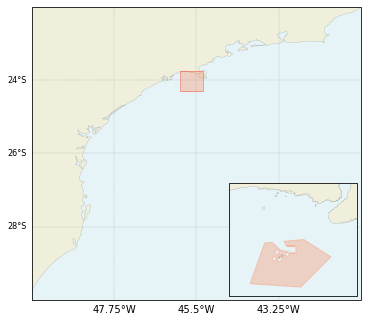

In [164]:
import cartopy.io.shapereader as shpreader

import shapely.geometry as sgeom

# criando a base do mapa:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent)

# coordenadas geográficas do limite do minimapa
lower_lat = -24.3
lower_lon = -45.949
upper_lat = -23.74
upper_lon = -45.32

extent_UC = [lower_lon, upper_lon, lower_lat, upper_lat]

# usando um método novo do matplotlib, criamos um polígono
extent_box = sgeom.box(extent_UC[0], extent_UC[2], 
                       extent_UC[1], extent_UC[3])

# adicionando polígono no mapa
ax.add_geometries([extent_box], ccrs.PlateCarree(), 
                  facecolor='coral', # cor do polígono
                  edgecolor='red',   # cor das arestas
                  alpha=.3)          # transparência

# setting axes position and size
left   = 0.465
bottom = 0.25
width  = 0.55
height = 0.20

rect = [left,bottom,width,height]

# creating axes 2 for minimap
ax2 = plt.axes(rect, projection=ccrs.PlateCarree())
ax2 = make_map(fig=fig, ax=ax2, extent=extent_UC)

# adicionando linha de costa do OpenStreetMap
line = shapereader.Reader('../dados/OSM/OSM_BRA_coastline/lines.shp')
ax2.add_geometries(line.geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='black',linewidth=.05)

# adicionando continente do OpenStreetMap
land = shapereader.Reader('../dados/OSM/OSM_BRA_land/land.shp')
ax2.add_geometries(land.geometries(), ccrs.PlateCarree(),facecolor=cfeature.COLORS['land'],edgecolor='black',linewidth=0.05)

# adicionando área da unidade de conservação (terra e água)
ucs = shapereader.Reader('../dados/alcatrazes/alcatrazes.shp')
ax2.add_geometries(ucs.geometries(), ccrs.PlateCarree(),facecolor='coral',alpha=.3,edgecolor='coral')


Agora temos toda a região da Unidade de Conservação indicada no minimapa!

Para deixarmos nosso código mais completo e organizado, vamos transformar estas últimas ações em uma função chamada ```create_alcatrazes()```:

In [166]:
def create_alcatrazes(ax):

    # coordenadas geográficas do limite do minimapa
    lower_lat = -24.3
    lower_lon = -45.949
    upper_lat = -23.74
    upper_lon = -45.32

    extent_UC = [lower_lon, upper_lon, lower_lat, upper_lat]

    # usando um método novo do matplotlib, criamos um polígono
    extent_box = sgeom.box(extent_UC[0], extent_UC[2], 
                           extent_UC[1], extent_UC[3])

    # adicionando polígono no mapa
    ax.add_geometries([extent_box], ccrs.PlateCarree(), 
                      facecolor='coral', # cor do polígono
                      edgecolor='red',   # cor das arestas
                      alpha=.3)          # transparência

    # setting axes position and size
    left   = 0.465
    bottom = 0.25
    width  = 0.55
    height = 0.20

    rect = [left,bottom,width,height]

    # creating axes 2 for minimap
    ax2 = plt.axes(rect, projection=ccrs.PlateCarree())
    ax2 = make_map(fig=fig, ax=ax2, extent=extent_UC)

    # adicionando linha de costa do OpenStreetMap
    line = shapereader.Reader('../dados/OSM/OSM_BRA_coastline/lines.shp')
    ax2.add_geometries(line.geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='black',linewidth=.05)

    # adicionando continente do OpenStreetMap
    land = shapereader.Reader('../dados/OSM/OSM_BRA_land/land.shp')
    ax2.add_geometries(land.geometries(), ccrs.PlateCarree(),facecolor=cfeature.COLORS['land'],edgecolor='black',linewidth=0.05)

    # adicionando área da unidade de conservação (terra e água)
    ucs = shapereader.Reader('../dados/alcatrazes/alcatrazes.shp')
    ax2.add_geometries(ucs.geometries(), ccrs.PlateCarree(),facecolor='coral',alpha=.3,edgecolor='coral')
    
    return ax2

Agora temos três funções para reproduzir nosso mapa e só falta inserirmos informações nele.

Para este fim, vamos inserir  a localização de algumas estações meteorológicas e bóias fundeadas nessa região.

In [173]:
# criando dicionário com os locais e metadados

insitu = {
    'simcosta-css': {
        'coords': (-23.831, -45.423), # lat,lon
        'marker': 's',
        'color': 'purple',
        'label': 'SiMCosta - SP',
        'minimap': True # plotar no minimapa?
    },
    
    'simcosta-rj': {
        'coords': (-22.967, -43.131),
        'marker': 's',
        'color': 'green',
        'label': 'SiMCosta - RJ',
        'minimap': False
    },
    
    'base-ubatuba': {
        'coords': (-23.499, -45.119),
        'marker': 'o',
        'color': 'k',
        'label': 'Base Ubatuba (IOUSP)',
        'minimap': False
        
    },
    'base-cananeia': {
        'coords': (-25.02, -47.925),
        'marker': 'o',
        'color': 'r',
        'label': u'Base Cananéia (IOUSP)',
        'minimap': False
    }
}

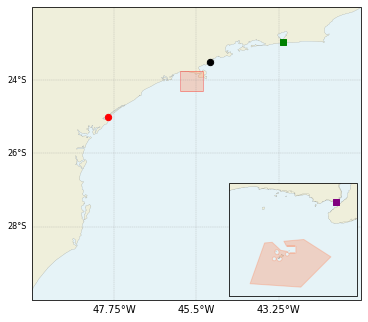

In [175]:
# código completo
# projecao
proj = ccrs.PlateCarree()

# posicao do canto inferior esquerdo
lower_lon = -50
lower_lat = -30

# posicao do canto superior direito
upper_lon = -41
upper_lat = -22

# montando uma lista para facilitar enviar para o GeoAxes
# os limites geográficos. 
extent = [lower_lon, upper_lon, lower_lat, upper_lat]

# criando a base do mapa:
fig = plt.figure(figsize=(15/2.54,20/2.54))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent)

# inserindo o minimapa completo
ax2 = create_alcatrazes(ax)

# inserindo marcadores de pontos de observação
for local,metadados in insitu.items():
    # extraindo metadados
    lat,lon = metadados['coords']
    marker = metadados['marker']
    color = metadados['color']
    label = metadados['label']
    
    # varia o ax_plot de acordo com o mapa que deve exibir a informação
    if metadados['minimap']:
        ax_plot = ax2
    else:
        ax_plot = ax
        
    ax_plot.scatter(lon, lat, s=40, marker=marker, color=color, label=label, zorder=50)

plt.savefig('mapa_alcatrazes.png', dpi=150)

**Exercícios**

Sabendo como elaborar um mapa, utilize o conjunto de informações da última aula para reproduzir alguns mapas.

1) Faça um mapa indicando os Estados mais afetados, utilizando como marker='o' (uma bola) e essa bola deve variar de tamanho segundo a quantidade de regiões atingidas apenas.

2) Selecione uma das regiões acima e reproduza um mapa mais detalhado, indicando as praias que foram atingidas. Tente variar as cores dos marcadores segundo a evolução temporal: primeira afetada com uma cor e varia até a cor da última afetada.

3) Utilize a coluna "dias" do dataframe e refaça o mapa 1), mas agora varie o tamanho dos marcadores segundo o tempo de permanência somado dos Estados. Para isso use o agrupamento do pandas com o método ```.sum()```.

Para auxiliar, é necessário converter o formato de latitude e longitude presente no dataframe. Para isso, use a função abaixo, obtida com o [Filipe Fernandes](ttps://gist.github.com/ocefpaf/60bec6fbd252107de11073376bad7925) e insira essa função usando o método ```.apply()``` do pandas para converter.

```python
df['new_lon'] = df['Longitude'].apply(fix_pos)
```

In [ ]:
def fix_pos(pos):
    # source: ttps://gist.github.com/ocefpaf/60bec6fbd252107de11073376bad7925
    deg, rest = pos.split("°")
    mi, rest = rest.strip().split("'")
    sec, hem = rest.strip().split('"')
    hem = hem.strip()

    deg, mi, sec = map(float, (deg, mi, sec))
    if hem in ["S", "W"]:
        sign = -1
    elif hem in ["N", "E"]:
        sign = +1
    else:
        raise ValueError(f"Unrecognized sign {sign}, expected 'S', 'W', 'E', or 'N'")

    return sign * (deg + mi/60 + sec/60/60)